In [1]:
import json
from collections import Counter
import numpy as np
import operator
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import networkx as nx
import base64
from collections import defaultdict
import sys,os
import math
import random
import operator
import csv
import matplotlib.pylab as pyl
import itertools
import scipy as sp
from scipy import stats
from scipy import optimize
from scipy.integrate import quad

In [9]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)


# setting up dataframe which will be updated throughout the notebook
final_df = pd.DataFrame()

# get data from european championship 
england_events = pd.DataFrame(events['England'])

#  start to aggregate the events data by match and team. 

# find type of events 'subEventName'
subevent = england_events['subEventName'].value_counts()

# find all types of events with "pass"
pass_events = england_events[england_events['subEventName'].str.contains('pass',case=False)]
pass_events['subEventName'].value_counts()

# I will start with the following: aggregate the data for each match and team, and count the total number of passes for each type ("Simple pass", "High pass", "Head pass", "Smart pass", "Hand pass"). 
pass_data = pass_events.groupby(['matchId','teamId','subEventName']).size().unstack().fillna(0)
pass_data = pass_data.reset_index()
pass_data.columns = ['matchId','teamId','Hand pass','Head pass','High pass','Simple pass','Smart pass']

final_df = pass_data

def calculate_average_distance_for_subevent(df, subEventName):
    # Filter the dataset for the specified subEventName
    filtered_df = df[df['subEventName'] == subEventName]
    
    # Calculate the distance for each event
    # Assuming positions are stored as [{'x': startX, 'y': startY}, {'x': endX, 'y': endY}]
    filtered_df['distance'] = filtered_df.apply(lambda row: np.sqrt((row['positions'][1]['x'] - row['positions'][0]['x'])**2 + (row['positions'][1]['y'] - row['positions'][0]['y'])**2), axis=1)
    
    # Group by matchId and teamId, then calculate the average distance
    result = filtered_df.groupby(['matchId', 'teamId'])['distance'].mean().reset_index()
    
    # Rename the distance column to 'average_distance'
    result.rename(columns={'distance': 'average_distance'}, inplace=True)
    
    return result

# Calculate the average distance for each subevent
simple_pass_avg_distance = calculate_average_distance_for_subevent(england_events, 'Simple pass')
high_pass_avg_distance = calculate_average_distance_for_subevent(england_events, 'High pass')
head_pass_avg_distance = calculate_average_distance_for_subevent(england_events, 'Head pass')
smart_pass_avg_distance = calculate_average_distance_for_subevent(england_events, 'Smart pass')
hand_pass_avg_distance = calculate_average_distance_for_subevent(england_events, 'Hand pass')

# Merge the results
final_df = final_df.merge(simple_pass_avg_distance, on=['matchId', 'teamId'], how='left', suffixes=('', '_simple_pass'))
final_df = final_df.merge(high_pass_avg_distance, on=['matchId', 'teamId'], how='left', suffixes=('', '_high_pass'))
final_df = final_df.merge(head_pass_avg_distance, on=['matchId', 'teamId'], how='left', suffixes=('', '_head_pass'))
final_df = final_df.merge(smart_pass_avg_distance, on=['matchId', 'teamId'], how='left', suffixes=('', '_smart_pass'))
final_df = final_df.merge(hand_pass_avg_distance, on=['matchId', 'teamId'], how='left', suffixes=('', '_hand_pass'))

final_df['total_passes'] = final_df['Hand pass'] + final_df['Head pass'] + final_df['High pass'] + final_df['Simple pass'] + final_df['Smart pass']
final_df['Proportion Hand pass'] = final_df['Hand pass'] / final_df['total_passes']
final_df['Proportion Head pass'] = final_df['Head pass'] / final_df['total_passes']
final_df['Proportion High pass'] = final_df['High pass'] / final_df['total_passes']
final_df['Proportion Simple pass'] = final_df['Simple pass'] / final_df['total_passes']
final_df['Proportion Smart pass'] = final_df['Smart pass'] / final_df['total_passes']

# change NAN values to 0 in the dataframe
final_df = final_df.fillna(0)

final_df['average_pass_length'] = (final_df['Hand pass']*final_df['average_distance_hand_pass'] + final_df['Head pass']*final_df['average_distance_head_pass'] + final_df['High pass']*final_df['average_distance_high_pass'] + final_df['Simple pass']*final_df['average_distance'] + final_df['Smart pass']*final_df['average_distance_smart_pass']) / final_df['total_passes']

def calculate_progression_for_subevent(df, subEventName):
    # Filter the dataset for the specified subEventName
    filtered_df = df[df['subEventName'] == subEventName]
    
    # Calculate the progression for each event using only the x coordinate
    # Positions are stored in y and then x format
    filtered_df['progression'] = filtered_df.apply(lambda row: row['positions'][1]['x'] - row['positions'][0]['x'], axis=1)
    
    # Group by matchId and teamId, then calculate the average progression per pass
    result = filtered_df.groupby(['matchId', 'teamId'])['progression'].mean().reset_index()
    
    # Rename the progression column to 'average_progression_per_pass'
    result.rename(columns={'progression': 'average_progression_per_pass'}, inplace=True)
    
    return result

# Calculate the average progression per pass for each subevent
simple_pass_avg_progression = calculate_progression_for_subevent(england_events, 'Simple pass')
high_pass_avg_progression = calculate_progression_for_subevent(england_events, 'High pass')
head_pass_avg_progression = calculate_progression_for_subevent(england_events, 'Head pass')
smart_pass_avg_progression = calculate_progression_for_subevent(england_events, 'Smart pass')
hand_pass_avg_progression = calculate_progression_for_subevent(england_events, 'Hand pass')

# Merge the results
final_df = final_df.merge(simple_pass_avg_progression, on=['matchId', 'teamId'], how='left', suffixes=('', '_simple_pass'))
final_df = final_df.merge(high_pass_avg_progression, on=['matchId', 'teamId'], how='left', suffixes=('', '_high_pass'))
final_df = final_df.merge(head_pass_avg_progression, on=['matchId', 'teamId'], how='left', suffixes=('', '_head_pass'))
final_df = final_df.merge(smart_pass_avg_progression, on=['matchId', 'teamId'], how='left', suffixes=('', '_smart_pass'))
final_df = final_df.merge(hand_pass_avg_progression, on=['matchId', 'teamId'], how='left', suffixes=('', '_hand_pass'))


def calculate_success_rate_for_subevent(df, subEventName):
    # Filter the dataset for the specified subEventName
    filtered_df = df[df['subEventName'] == subEventName]
    
    # Calculate the success rate for each event
    filtered_df['success'] = filtered_df['tags'].apply(lambda x: 1 if 1801 in [tag['id'] for tag in x] else 0)
    
    # Group by matchId and teamId, then calculate the success rate
    result = filtered_df.groupby(['matchId', 'teamId'])['success'].mean().reset_index()
    
    # Rename the success column to 'success_rate'
    result.rename(columns={'success': 'success_rate'}, inplace=True)
    
    return result

# Calculate the success rate for each subevent
simple_pass_success_rate = calculate_success_rate_for_subevent(england_events, 'Simple pass')
high_pass_success_rate = calculate_success_rate_for_subevent(england_events, 'High pass')
head_pass_success_rate = calculate_success_rate_for_subevent(england_events, 'Head pass')
smart_pass_success_rate = calculate_success_rate_for_subevent(england_events, 'Smart pass')
hand_pass_success_rate = calculate_success_rate_for_subevent(england_events, 'Hand pass')

# Merge the results
final_df = final_df.merge(simple_pass_success_rate, on=['matchId', 'teamId'], how='left', suffixes=('', '_simple_pass'))
final_df = final_df.merge(high_pass_success_rate, on=['matchId', 'teamId'], how='left', suffixes=('', '_high_pass'))
final_df = final_df.merge(head_pass_success_rate, on=['matchId', 'teamId'], how='left', suffixes=('', '_head_pass'))
final_df = final_df.merge(smart_pass_success_rate, on=['matchId', 'teamId'], how='left', suffixes=('', '_smart_pass'))
final_df = final_df.merge(hand_pass_success_rate, on=['matchId', 'teamId'], how='left', suffixes=('', '_hand_pass'))


# I don't think that hand passes are useful. Remove all columns that contain the word "hand"
final_df = final_df[final_df.columns.drop(list(final_df.filter(regex='hand')))]
final_df = final_df[final_df.columns.drop(list(final_df.filter(regex='Hand')))]

def calculate_PPDA(df):
    # Filter the dataset for the specified defensive actions
    defensive_actions = df[(df['subEventName'] == 'Ground defending duel') | (df['subEventName'] == 'Sliding tackle') | (df['subEventName'] == 'Foul')]
    
    # Calculate the PPDA for each defensive action
    defensive_actions['PPDA'] = defensive_actions['teamId'].apply(lambda x: 1)
    
    # Group by matchId and teamId, then calculate the PPDA
    result = defensive_actions.groupby(['matchId', 'teamId'])['PPDA'].sum().reset_index()
    
    # Filter the dataset for the specified passes
    passes = df[df['subEventName'] == 'Simple pass']
    
    # Calculate the PPDA for each pass
    passes['PPDA'] = passes['teamId'].apply(lambda x: 1)
    
    # Group by matchId and teamId, then calculate the PPDA
    passes = passes.groupby(['matchId', 'teamId'])['PPDA'].sum().reset_index()
    
    # Merge the results
    result = result.merge(passes, on=['matchId', 'teamId'], how='left', suffixes=('', '_passes'))
    
    # Calculate the PPDA
    result['PPDA'] = result['PPDA_passes'] / result['PPDA']

    # drop PPDA_passes column
    result = result.drop('PPDA_passes', axis=1)
    
    return result

# Calculate PPDA for each team
PPDA = calculate_PPDA(england_events)

# merge the PPDA data with the final_df
final_df = final_df.merge(PPDA, on=['matchId', 'teamId'], how='left')

# compute number of each defensive action per match and team. Defensive actions are: Ground defending duel, foul, ground loose ball duel, Ground attacking duel 
defensive_actions = england_events[(england_events['subEventName'] == 'Ground defending duel') | (england_events['subEventName'] == 'Foul') | (england_events['subEventName'] == 'Ground loose ball duel') | (england_events['subEventName'] == 'Ground attacking duel')]
defensive_actions = defensive_actions.groupby(['matchId', 'teamId', 'subEventName']).size().unstack().fillna(0)
defensive_actions = defensive_actions.reset_index()
defensive_actions.columns = ['matchId','teamId','Foul','Ground attacking duel','Ground defending duel','Ground loose ball duel']

final_df = final_df.merge(defensive_actions, on=['matchId', 'teamId'], how='left')

def calculate_average_height_for_defensive_action(df, subEventName):
    # Filter the dataset for the specified subEventName
    filtered_df = df[df['subEventName'] == subEventName]
    
    # Calculate the height for each event
    # Assuming positions are stored as [{'x': startX, 'y': startY}, {'x': endX, 'y': endY}]
    filtered_df['height'] = filtered_df['positions'].apply(lambda x: x[0]['x'])
    
    # Group by matchId and teamId, then calculate the average height
    result = filtered_df.groupby(['matchId', 'teamId'])['height'].mean().reset_index()
    
    # Rename the height column to 'average_height'
    result.rename(columns={'height': 'average_height'}, inplace=True)
    
    return result

# Calculate the average height for each defensive action
ground_defending_duel_avg_height = calculate_average_height_for_defensive_action(england_events, 'Ground defending duel')
foul_avg_height = calculate_average_height_for_defensive_action(england_events, 'Foul')
ground_loose_ball_duel_avg_height = calculate_average_height_for_defensive_action(england_events, 'Ground loose ball duel')
ground_attacking_duel_avg_height = calculate_average_height_for_defensive_action(england_events, 'Ground attacking duel')


# Merge the results
final_df = final_df.merge(ground_defending_duel_avg_height, on=['matchId', 'teamId'], how='left', suffixes=('', '_ground_defending_duel'))
final_df = final_df.merge(foul_avg_height, on=['matchId', 'teamId'], how='left', suffixes=('', '_foul'))
final_df = final_df.merge(ground_loose_ball_duel_avg_height, on=['matchId', 'teamId'], how='left', suffixes=('', '_ground_loose_ball_duel'))
final_df = final_df.merge(ground_attacking_duel_avg_height, on=['matchId', 'teamId'], how='left', suffixes=('', '_ground_attacking_duel'))

final_df = final_df.fillna(0)

C:\Users\fkort\AppData\Local\Temp\ipykernel_34896\180469789.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['distance'] = filtered_df.apply(lambda row: np.sqrt((row['positions'][1]['x'] - row['positions'][0]['x'])**2 + (row['positions'][1]['y'] - row['positions'][0]['y'])**2), axis=1)
C:\Users\fkort\AppData\Local\Temp\ipykernel_34896\180469789.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['distance'] = filtered_df.apply(lambda row: np.sqrt((row['positions'][1]['x'] - row[

In [11]:
# aggregate the data per team, count the total number of games each team has played and sum all the data for each team and divide by the number of games played
team_data = final_df.groupby('teamId').sum()
team_data['matches_played'] = final_df.groupby('teamId')['matchId'].nunique()
team_data = team_data.div(team_data['matches_played'], axis=0)
team_data = team_data.drop('matches_played', axis=1)

# drop matchId column
team_data = team_data.drop('matchId', axis=1)

team_data

,Head pass,High pass,Simple pass,Smart pass,average_distance,average_distance_high_pass,average_distance_head_pass,average_distance_smart_pass,total_passes,Proportion Head pass,...,success_rate_smart_pass,PPDA,Foul,Ground attacking duel,Ground defending duel,Ground loose ball duel,average_height,average_height_foul,average_height_ground_loose_ball_duel,average_height_ground_attacking_duel
teamId,,,,,,,,,,,,,,,,,,,,,
1609,26.342105,31.236842,499.868421,13.289474,20.959956,44.394183,17.954015,22.647134,576.552632,0.048123,...,0.384593,6.520773,9.657895,69.710526,71.210526,37.078947,40.621779,50.015542,49.589982,61.666500
1610,22.473684,32.710526,440.815789,9.921053,21.623563,45.500236,19.224262,22.671507,510.368421,0.046226,...,0.391714,6.281072,8.842105,82.263158,68.447368,39.368421,38.176547,52.160720,48.545931,62.180442
1611,21.368421,31.894737,413.421053,11.263158,20.408503,44.979784,19.184419,22.197032,481.184211,0.048807,...,0.372007,5.625129,10.289474,81.631579,70.421053,39.789474,39.548729,54.681041,50.255612,62.493845
1612,28.210526,34.684211,474.263158,13.131579,22.120031,45.477026,19.363233,21.666210,554.868421,0.054752,...,0.392973,6.873323,8.578947,73.315789,66.315789,39.342105,41.927223,51.644108,51.344052,64.021658
1613,28.842105,34.894737,239.394737,5.921053,19.942658,43.342451,18.203176,24.827289,311.526316,0.098967,...,0.341773,2.917206,10.289474,63.078947,77.105263,44.289474,37.549602,50.572093,48.214226,59.319512
1619,31.131579,36.342105,325.815789,7.894737,20.921684,45.543549,19.006128,23.388098,403.736842,0.080798,...,0.337772,4.012621,10.763158,67.184211,75.631579,43.157895,38.582653,52.602985,49.937188,61.017901
1623,29.394737,34.578947,266.894737,4.921053,21.083722,46.162024,19.467405,26.269893,339.342105,0.090008,...,0.345526,3.069640,11.526316,64.763158,78.763158,47.236842,38.571531,52.371355,49.601373,60.351060
1624,26.105263,34.921053,446.500000,11.947368,21.740445,44.330102,18.260451,23.183570,523.684211,0.051806,...,0.370630,6.262670,9.447368,80.526316,65.763158,41.815789,42.601662,53.536977,53.122574,63.260137
1625,22.157895,26.789474,633.184211,14.710526,20.825311,48.920889,18.934712,22.656913,700.868421,0.033082,...,0.442865,10.406124,8.526316,73.552632,56.394737,37.236842,44.610941,54.273341,53.415009,66.556299


In [12]:
with open('./data/teams.json') as json_data:
    teams = json.load(json_data)

teams = pd.DataFrame(teams)

# match the teamId from the final_df with the teamId from the teams data and the officialName of the team and store it into a disctionary
team_dict = dict(zip(teams['wyId'], teams['officialName']))

# add the officialName of the team to the team_data dataframe
team_data['team'] = team_data.index.map(team_dict)

# move the team column to the front of the dataframe
cols = team_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
team_data = team_data[cols]

# change average_distance to average_distance_simple_pass
team_data = team_data.rename(columns={'average_distance': 'average_distance_simple_pass'})
# change sucess_rate to success_rate_simple_pass
team_data = team_data.rename(columns={'success_rate': 'success_rate_simple_pass'})
# change average_progression_per_pass to average_progression_per_pass_simple_pass
team_data = team_data.rename(columns={'average_progression_per_pass': 'average_progression_per_pass_simple_pass'})
# average_height to average_height_ground_defending_duel
team_data = team_data.rename(columns={'average_height': 'average_height_ground_defending_duel'})

# I have the variables for average distance for each pass type, now I want to combine those into a variable that represents the average distance for all passes.
# multiply number of passes with the distance for each pass type and sum all the distances and divide by the total number of passes
team_data['average_pass_distance'] = (team_data['Simple pass']*team_data['average_distance_simple_pass'] + team_data['High pass']*team_data['average_distance_high_pass'] + team_data['Head pass']*team_data['average_distance_head_pass'] + team_data['Smart pass']*team_data ['average_distance_smart_pass']) / team_data['total_passes']

# I want to calculate the average progression of the total passes 
team_data['average_pass_progression'] = (team_data['Simple pass']*team_data['average_progression_per_pass_simple_pass'] + team_data['High pass']*team_data['average_progression_per_pass_high_pass'] + team_data['Head pass']*team_data['average_progression_per_pass_head_pass'] + team_data['Smart pass']*team_data['average_progression_per_pass_smart_pass']) / team_data['total_passes']

# I want to calculate the average success rate of the total passes
# multiplying the number of passes with the success rate for each pass type and sum all the success rates and divide by the total number of passes
team_data['average_pass_success_rate'] = (team_data['Simple pass']*team_data['success_rate_simple_pass'] + team_data['High pass']*team_data['success_rate_high_pass'] + team_data['Head pass']*team_data['success_rate_head_pass'] + team_data['Smart pass']*team_data['success_rate_smart_pass']) / team_data['total_passes']

In [15]:
# reset index
team_data = team_data.reset_index(drop=True)
team_data

,team,Head pass,High pass,Simple pass,Smart pass,average_distance_simple_pass,average_distance_high_pass,average_distance_head_pass,average_distance_smart_pass,total_passes,...,Ground attacking duel,Ground defending duel,Ground loose ball duel,average_height_ground_defending_duel,average_height_foul,average_height_ground_loose_ball_duel,average_height_ground_attacking_duel,average_pass_distance,average_pass_progression,average_pass_success_rate
0,Arsenal FC,26.342105,31.236842,499.868421,13.289474,20.959956,44.394183,17.954015,22.647134,576.552632,...,69.710526,71.210526,37.078947,40.621779,50.015542,49.589982,61.666500,21.919715,4.422682,0.871574
1,Chelsea FC,22.473684,32.710526,440.815789,9.921053,21.623563,45.500236,19.224262,22.671507,510.368421,...,82.263158,68.447368,39.368421,38.176547,52.160720,48.545931,62.180442,22.880157,4.644718,0.873491
2,Manchester United FC,21.368421,31.894737,413.421053,11.263158,20.408503,44.979784,19.184419,22.197032,481.184211,...,81.631579,70.421053,39.789474,39.548729,54.681041,50.255612,62.493845,21.887403,4.450781,0.874153
3,Liverpool FC,28.210526,34.684211,474.263158,13.131579,22.120031,45.477026,19.363233,21.666210,554.868421,...,73.315789,66.315789,39.342105,41.927223,51.644108,51.344052,64.021658,23.246609,4.511431,0.872423
4,Newcastle United FC,28.842105,34.894737,239.394737,5.921053,19.942658,43.342451,18.203176,24.827289,311.526316,...,63.078947,77.105263,44.289474,37.549602,50.572093,48.214226,59.319512,22.337158,6.088450,0.804779
5,Southampton FC,31.131579,36.342105,325.815789,7.894737,20.921684,45.543549,19.006128,23.388098,403.736842,...,67.184211,75.631579,43.157895,38.582653,52.602985,49.937188,61.017901,22.906250,5.224689,0.834629
6,Everton FC,29.394737,34.578947,266.894737,4.921053,21.083722,46.162024,19.467405,26.269893,339.342105,...,64.763158,78.763158,47.236842,38.571531,52.371355,49.601373,60.351060,23.353670,5.739561,0.810150
7,Tottenham Hotspur FC,26.105263,34.921053,446.500000,11.947368,21.740445,44.330102,18.260451,23.183570,523.684211,...,80.526316,65.763158,41.815789,42.601662,53.536977,53.122574,63.260137,22.931452,4.763363,0.869960
8,Manchester City FC,22.157895,26.789474,633.184211,14.710526,20.825311,48.920889,18.934712,22.656913,700.868421,...,73.552632,56.394737,37.236842,44.610941,54.273341,53.415009,66.556299,21.758252,3.471290,0.911115
9,West Bromwich Albion FC,30.973684,37.184211,221.078947,4.342105,20.429678,43.731374,18.474559,24.212571,295.078947,...,73.184211,70.736842,41.026316,36.799421,50.501580,50.503416,59.903413,23.112618,6.562668,0.800313


explained variance ratio:  [0.52337399 0.11459129 0.08535349]
total variance explained:  0.723318766300204


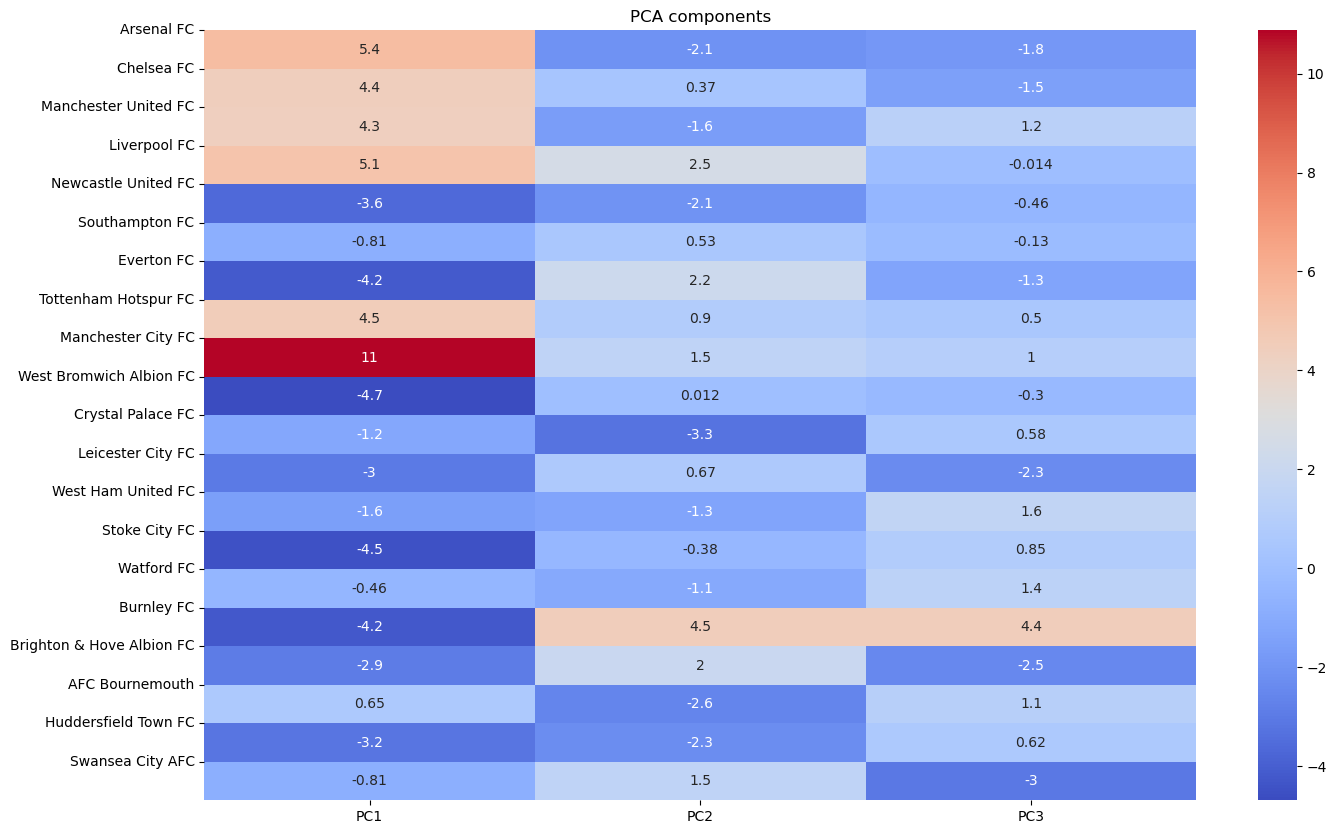

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# drop team from the data
features = team_data.drop(['team'], axis=1)

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(scaled_features)

# Create a dataframe with the principal components
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
pca_df['team'] = team_data['team']

print("explained variance ratio: ", pca.explained_variance_ratio_)
# total variance 
print("total variance explained: ", sum(pca.explained_variance_ratio_))

# plot heatmap of pca_df, use the team names as y axis and the principal components as x axis
plt.figure(figsize=(16, 10))
sns.heatmap(pca_df.drop('team', axis=1), annot=True, cmap='coolwarm')
plt.yticks(ticks=range(len(pca_df['team'])), labels=pca_df['team'], rotation=0)
plt.title('PCA components')
plt.show()

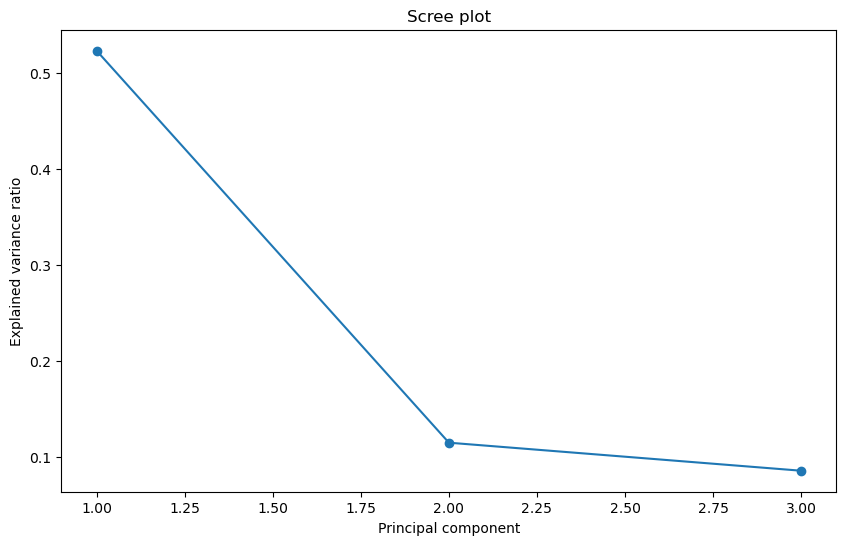

In [19]:
# scree plot 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree plot')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.show()

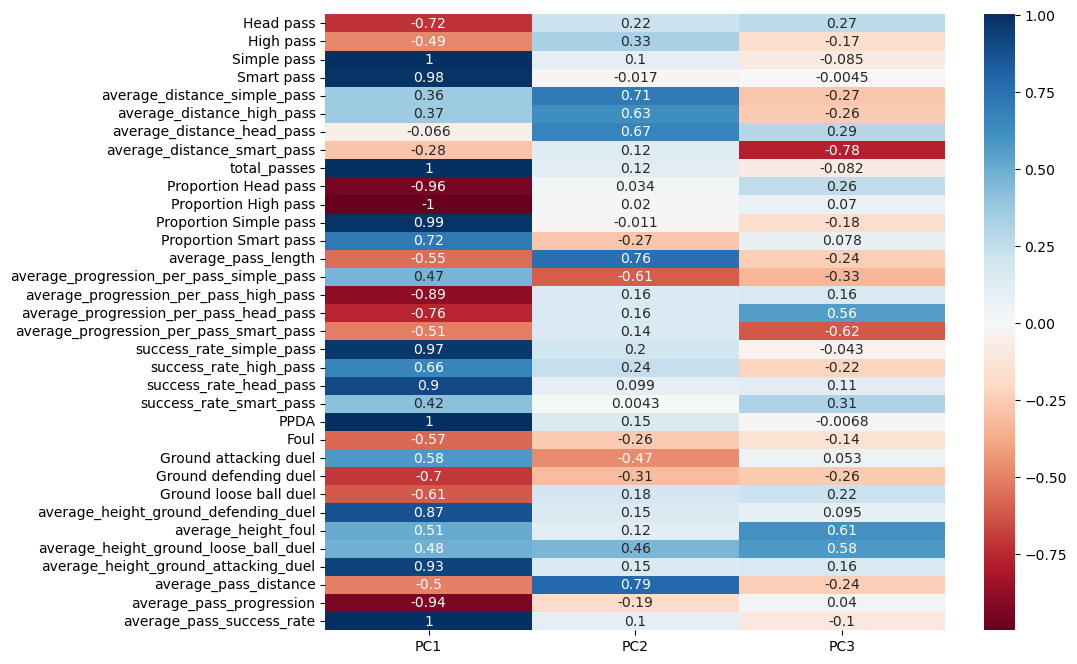

In [20]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=features.columns) 


plt.figure(figsize=(10, 8))
sns.heatmap(loading_matrix, annot=True, cmap='RdBu', xticklabels=True, yticklabels=True)
plt.show()

In [25]:
# kmeans 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)  # You can choose the number of clusters
clusters = kmeans.fit_predict(principalComponents)
pca_df['Cluster'] = clusters

# Explode the 'team' column so each team is in its own row
exploded_df = cluster_df.explode('team')

# Reset the index (optional)
exploded_df = exploded_df.reset_index(drop=True)

exploded_df

c:\Users\fkort\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\fkort\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Cluster,team
0,0,Newcastle United FC
1,0,Southampton FC
2,0,Crystal Palace FC
3,0,West Ham United FC
4,0,Watford FC
5,0,AFC Bournemouth
6,0,Huddersfield Town FC
7,1,Arsenal FC
8,1,Chelsea FC
9,1,Manchester United FC


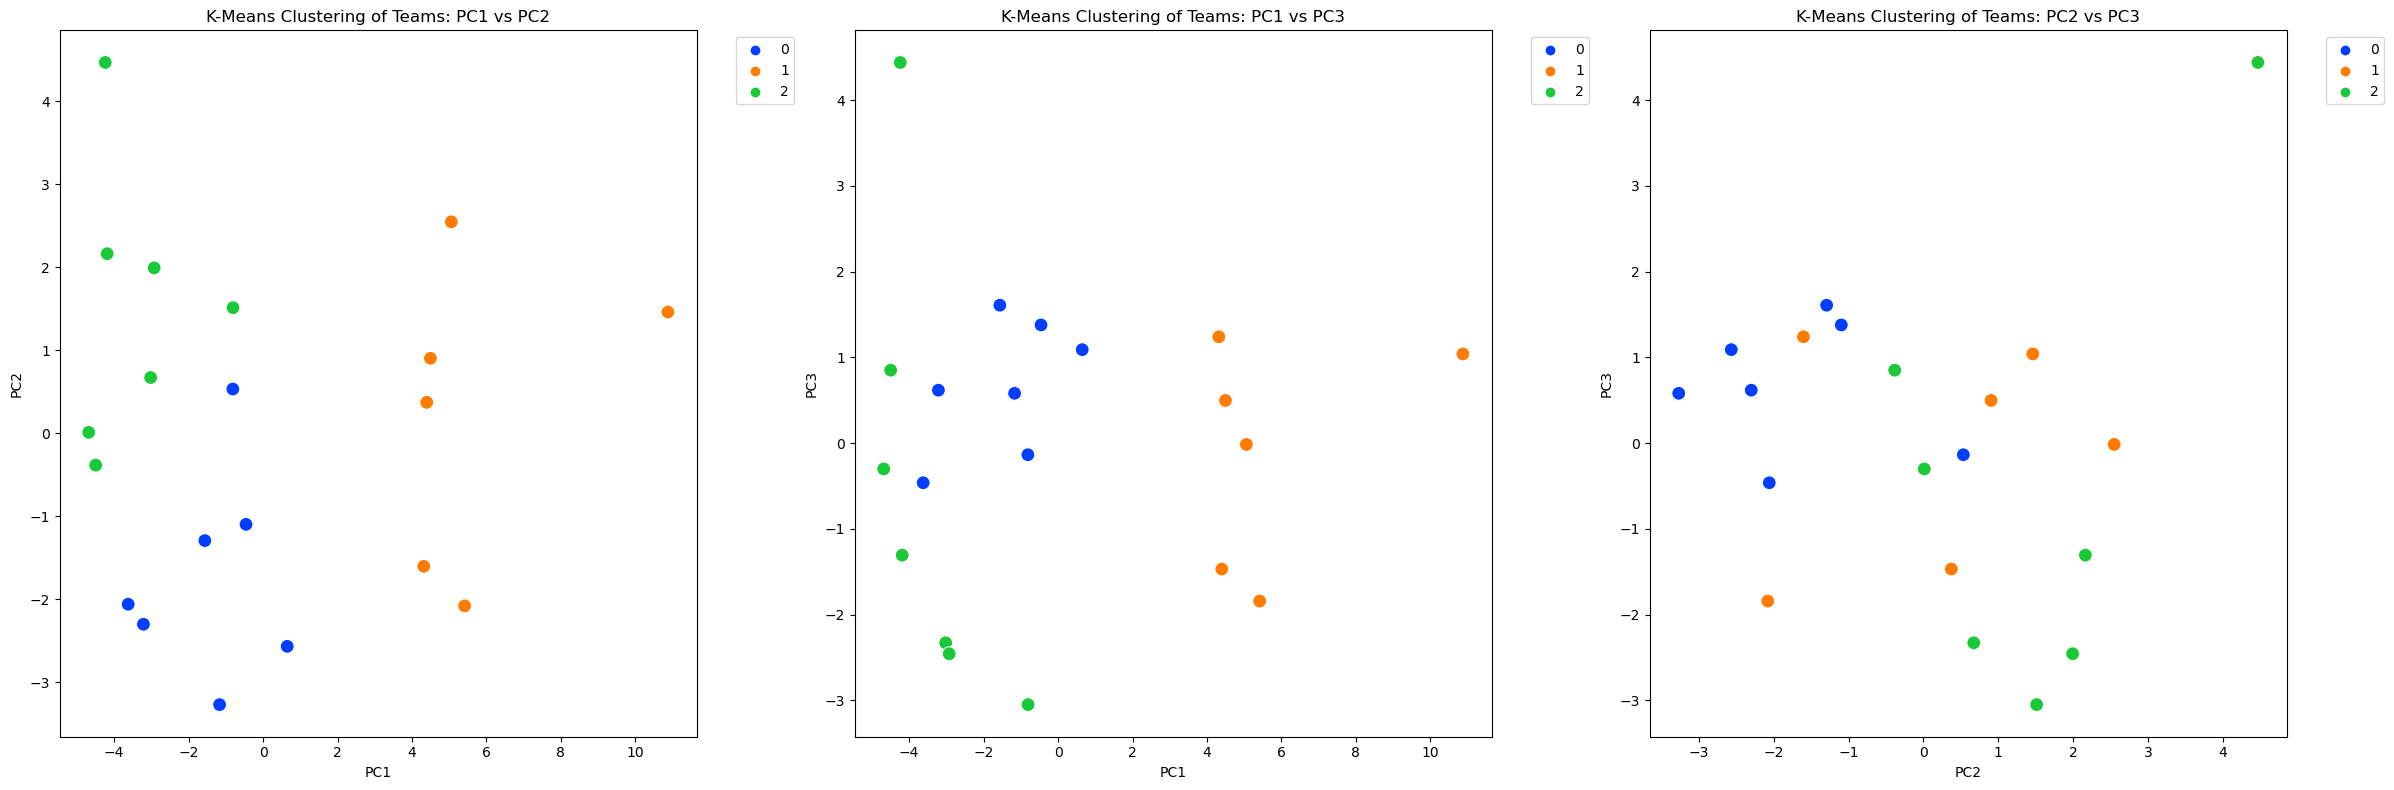

In [24]:
# Adjusting for a single row of square subplots
fig_width = 8 * 3  # Total width of the figure to accommodate 3 square subplots horizontally
fig_height = 8  # Height of each subplot to maintain square aspect ratio
fig, axs = plt.subplots(1, 3, figsize=(fig_width, fig_height))
axs = axs.flatten()

# Define PCA components to plot against each other
pca_components = ['PC1', 'PC2', 'PC3']
combinations = [(pca_components[i], pca_components[j]) for i in range(len(pca_components)) for j in range(i+1, len(pca_components))]

for i, (pca1, pca2) in enumerate(combinations):
    # Plot each PCA component against the other with increased point sizes
    sns.scatterplot(x=pca1, y=pca2, data=pca_df, hue='Cluster', palette='bright', legend='full', ax=axs[i], s=100)  # Adjust `s` as needed for point size
    axs[i].set_title(f'K-Means Clustering of Teams: {pca1} vs {pca2}')
    axs[i].set_xlabel(pca1)
    axs[i].set_ylabel(pca2)
    axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

In [ ]:
# average PPDA 